In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model

from src.yolo3.model import *
from src.yolo3.detect import *

from src.utils.image import *
from src.utils.datagen import *
from src.utils.fixes import *

fix_tf_gpu()

## **YOLO Model**

In [2]:
input_shape = (416, 416)
class_names  = ['W']

anchor_boxes = np.array(
    [
    np.array([[ 73, 158], [128, 209], [224, 246]]) /32, # output-1 anchor boxes
    np.array([[ 32,  50], [ 40, 104], [ 76,  73]]) /16, # output-2 anchor boxes
    np.array([[ 6,   11], [ 11,  23], [ 19,  36]]) /8   # output-3 anchor boxes
    ],
    dtype='float64'
)

num_classes = len(class_names)
num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

# input and output
input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

# build the model
model = yolo_body(input_tensor, num_out_filters)

# load weights
weight_path = f'model-data\weights\pictor-ppe-v302-a3-yolo-v3-weights.h5'
model.load_weights( weight_path )

## **Classifier Model**

In [3]:
clsfr_class_names  = ['W','WH','WV','WHV']

# input size of the classifier
clsfr_input_shape = (150, 150) # (224,224) for resnet, (299,299) fr xception

clsfr_mdl = load_model('model-data/weights/pictor-ppe-v302-a3-vgg16-weights.h5')

In [4]:
def get_detection(img):
    
    act_img = img.copy()
    ih, iw = act_img.shape[:2]

    # preprocess the image
    img = letterbox_image(img, input_shape)
    img = np.expand_dims(img, 0)
    image_data = np.array(img) / 255.

    prediction = model.predict(image_data)

    # process the raw prediction to get the bounding boxes
    boxes = detection(
        prediction,
        anchor_boxes,
        num_classes,
        image_shape = (ih, iw),
        input_shape = (416,416),
        max_boxes = 10,
        score_threshold=0.3,
        iou_threshold=0.45,
        classes_can_overlap=False)

    # convert tensor to numpy
    boxes = boxes[0].numpy()
    new_boxes = []

    for box in boxes:
        # get the top-left and bottom-right corner of the box
        x1, y1, x2, y2 = box[:4].astype(int)

        cropped_img = act_img[ y1:y2, x1:x2, : ]

        # resize the image
        cropped_img = letterbox_image(cropped_img, clsfr_input_shape)
        
        cropped_img = np.expand_dims( cropped_img/255., 0)

        # get prediction
        y_pred = clsfr_mdl.predict(cropped_img)

        # get the predicted class
        class_pred = np.argmax(y_pred[0])

        # store the predicted class in the box
        box[-1] = class_pred

        # store the prediction probability in the box
        box[-2] *= y_pred[0][class_pred]

        # store the new box with updated class and prob
        new_boxes.append(box)

    # convert to numpy
    new_boxes = np.array(new_boxes)

    # draw the detection on the actual image
    return draw_detection(act_img, boxes, clsfr_class_names)

## **Example**

In [5]:
def plt_imshow(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

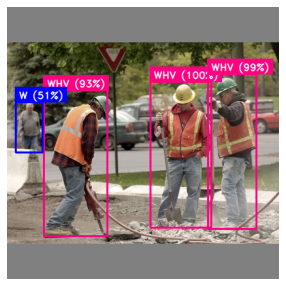

In [6]:
for i in range(1):
    # read the image
    img = cv2.imread( f'extras/sample-images/{i}.JPG' )

    # resize
    img = letterbox_image(img, input_shape)

    # get the detection on the image
    img = get_detection(img)

    # show the image
    plt_imshow(img[:, :, ::-1])

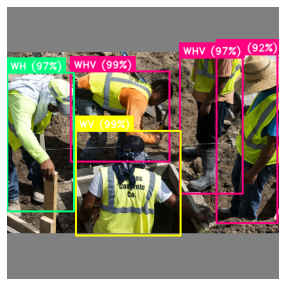

In [7]:
img = cv2.imread( f'extras/sample-images/7.JPG' )
img = letterbox_image(img, input_shape)    
img = get_detection(img)
plt_imshow(img[:, :, ::-1])